# ДЗ №2 - обучение многослойной нелинейной искусственной нейронной сети методом градиентного спуска

Реализовать обучение ИНС методом градиентного спуска.

В этом задании предлагается реализовать нейросеть по аналогии с ДЗ №1. На этот раз нейросеть должна быть многослойной; функции активации должны отличаться от идентичных. Можете использовать ReLU, сигмоид, гиперболический тангенс или вашу любимую. Материал для вдохновения в этом отношении можно искать [на Википедии](https://en.wikipedia.org/wiki/Activation_function)

В решении ожидается наличие следующих ключевых составляющих:<br />

#### Текстовое описание в решении:
- формулировка задачи, формулировка признакового описания объектов, формулировка функции ошибки;
- исследование исходных данных на предмет скоррелированности признаков; фильтрация признаков; порождение признаков (при необходимости; отсутствие этого шага не является недочетом, но вам же будет без него неудобно);
- оценка параметров модели ИНС (обучение модели) методом градиентного спуска;

#### Код решения:
(используйте предлагаемые шаблоны)
- формулировка всех составляющих модели "нейросети";
- формулировка модели "нейросети" - `NN` (многослойного перцептрона);
- формулировка функции ошибки вместе с ее составляющими (например, класс отклонения `Residual`);
- формулировка цикла оптимизации параметров.


#### Визуализация в решении:
- распределения признаков;
- распределение целевой переменной;
- эволюция функции ошибки и выбранных метрик качества по ходу обучения.
- диаграмма соответствия измеренной целевой переменной и значений целевой переменной, оцененной с использованием обученной "нейросети" (т.н. диаграмма рассеяния)

Примечания:

В этом ДЗ экспертное порождение новых признаков НЕ ДОПУСКАЕТСЯ. Все признаки должны быть выучены вашей нейросетью в процессе обучения.

Реализация нейросети может быть написана только с использованием библиотеки Numpy. Решения с использованием библиотек автоматического вычисления градиентов не засчитываются.

Данные находятся в следующих файлах:

Признаковое описание объектов обучающей выборки - в файле X_train.npy

Значения целевой переменной на обучающей выборке - в файле y_train.npy

Способ чтения данных из файлов *.npy :

```
import numpy as np
data = np.load('/path/to/filename.npy')
```

### Примечание на предмет реализации градиента функции потерь

В качестве шпаргалки можно подсмотреть правила матричного дифференцирования <a href="https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf">здесь</a>

В этом ДЗ следует очень аккуратно реализовать градиент каждой отдельной операции по аргументу этой операции:
- градиент квадрата отклонения $d^2$ - по отклонению $d$
- градиент отклонения $\left(\hat{y}-y\right)$ - по аргументу $\hat{y}$
- градиент функции активации $\hat{y}=A\left(z\right)$ - по ее агрументу $z$
- градиент оценки $z=\theta^T\cdot h$ - по аргументу $\theta$

**ВНИМАНИЕ**
В этом задании также следует учесть, что подразумевается, что метод `backward` каждого класса выдает градиент **функции ошибки** по аргументу операции. Для учета градиентов всех предыдущих операций в этот метод передается т.н. **upstream gradient** - переменная `usg`. Не забывайте ее передавать при "сборке" полного градиента. Эта "сборка" у вас будет в двух классах - классе функции потерь `MSE` (нужно собрать градиент операции `MSE` с учетом того, что она, в свою очередь, сложная функция, использующая `Residual`) и классе нейросети `NN`.

Как можно видеть, все операции, из которых составляется "нейросеть" в этом задании, могут быть представлены однотипно: для всех из них можно задать метод вычисления `forward` на "прямом проходе" и метод вычисления градиента `backward` на этапе вычисления градиентов, "обратном проходе".

**ВНИМАНИЕ**
Не следует забывать, что для вычисления градиентов обычно используются результаты операции, вычисленные на этапе "прямого прохода". Для хранения этих результатов используйте атрибуты класса `cache`. Напомним, ссылка на сам экземпляр класса в теле метода класса обычно упоминается как `self`. То есть, атрибут `cache` этого экземпляра класса будет в этом методе упоминаться как `self.cache`. Вы можете назвать его как угодно (не обязательно именно `cache`), но реализация хранения промежуточных результатов вычисления нейросети - **обязательно** в этом ДЗ.

In [1]:
import numpy as np
from tqdm import tqdm

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt

In [4]:
Xtr = np.load('./X_train.npy')
ytr = np.load('./y_train.npy')

Xtr = np.transpose(Xtr)
ytr = np.transpose(ytr)

In [5]:
ytr.shape

(1, 10000)

In [6]:
Xtr.shape

(4, 10000)

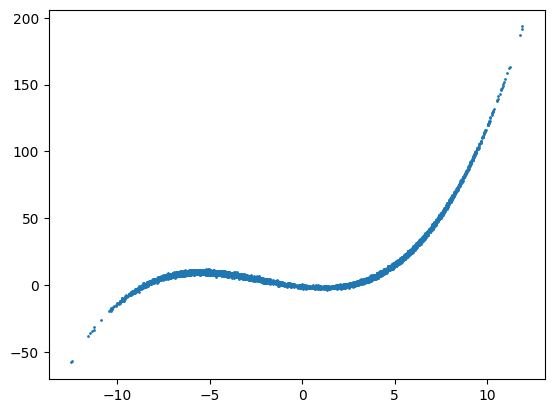

In [7]:
plt.scatter(Xtr[0,:], ytr, s=1)

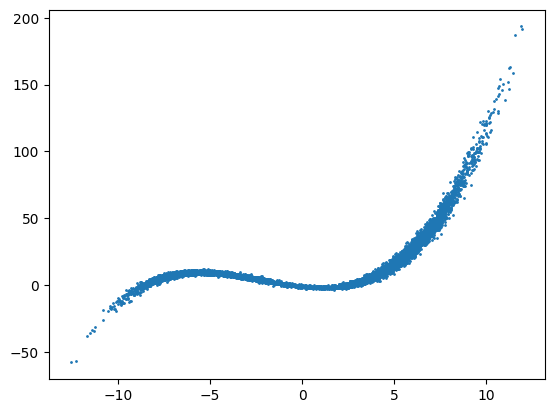

In [8]:
plt.scatter(Xtr[1,:], ytr, s=1)

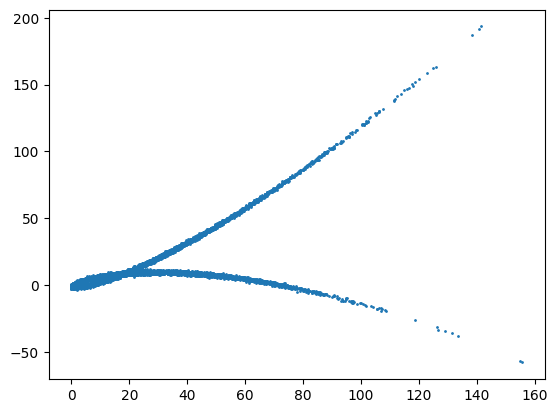

In [9]:
plt.scatter(Xtr[2,:], ytr, s=1)

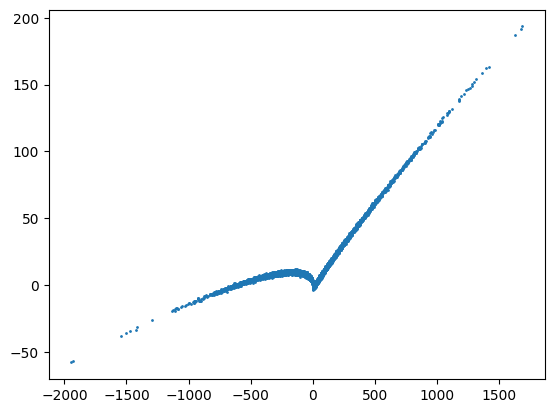

In [10]:
plt.scatter(Xtr[3,:], ytr, s=1)

In [11]:
np.corrcoef(np.transpose(Xtr), rowvar=False)

array([[1.        , 0.99930832, 0.00924955, 0.88100664],
       [0.99930832, 1.        , 0.0096915 , 0.88030952],
       [0.00924955, 0.0096915 , 1.        , 0.01899396],
       [0.88100664, 0.88030952, 0.01899396, 1.        ]])

In [12]:
# Примите решение о фильтрации признаков или порождении новых признаков
# Xtr = ...

In [13]:
class Differentiable:
    def __init__(self):
        pass
    
    def forward(self, **kwargs):
        raise NotImplementedError()
    
    def backward(self, **kwargs):
        raise NotImplementedError()

In [14]:
class Residual(Differentiable):
    def __init__(self):
        super(Residual, self).__init__()

    
    def __call__(self, mu, y):
        return self.forward(mu, y)

    
    def forward(self, mu, y):
        # Этот метод реализует вычисление отклонения mu-y
        d = np.subtract(mu, y)
        self.cache = d

        # 1*N
        return d

    
    def backward(self, usg):
        # Этот метод реализует вычисление градиента отклонения D по аргументу mu
        
        ### YOUR CODE HERE
        # partial_grad = np.diag([-1]*self.cache.shape[1], k=0)
        # partial_grad = np.matmul(usg, partial_grad)
        partial_grad = usg
        # print('residal b', partial_grad.shape)
        return partial_grad

In [15]:
class MSE(Differentiable):
    def __init__(self):
        super(MSE, self).__init__()
        
    
    def __call__(self, d):
        return self.forward(d)
        
    
    def forward(self, d):
        # Этот метод реализует вычисление значения функции потерь
        # Подсказка: метод должен возвращать единственный скаляр - значение функции потерь
        
        self.cache = d
        mse_value = np.divide(np.sum(np.square(d)), len(d))
        
        # print('mse', mse_value)
        
        return mse_value
        
    
    def backward(self):
        # Этот метод реализует вычисление градиента функции потерь по аргументу d
        # Подсказка: метод должен возвращать вектор градиента функции потерь
        #           размерностью, совпадающей с размерностью аргумента d
        
        ### YOUR CODE HERE
        n = 2 / (self.cache.shape[1])
        partial_grad = n * self.cache
        # self.cache = None
        # print('5', partial_grad.shape)

        # 1*N
        # print('MSE b', partial_grad.shape)
        # print('pg_MSE', partial_grad)
        return partial_grad
        

In [16]:
class linear(Differentiable):
    def __init__(self, m, k):
        super(linear, self).__init__()
        self.theta = None
        self.cache = None
        self.m = m
        self.k = k

    
    def __call__(self, X):
        # этот метод предназначен для вычисления значения целевой переменной
        return self.forward(X)

    
    def forward(self, X):
        # этот метод предназначен для применения модели к данным
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
        
        # ВНИМАНИЕ! Матрица объекты-признаки X не включает смещение
        #           Вектор единиц для применения смещения нужно присоединить самостоятельно!
        
        ### YOUR CODE HERE
        # X_ = ...
        
        if (self.theta is None):
            # Если вектор параметров еще не инициализирован, его следует инициализировать
            # Подсказка: длина вектора параметров может быть получена из размера матрицы X
            # Fx1.T dot NxF.T = 1xN
            # Если X - матрица объекты-признаки, то это матрица из вектор-строк!
            self.theta = np.matrix(np.random.uniform(-10, 10, [self.m+1, self.k]))
        
        
        # Здесь следует собственно применить модель к входным данным
        # print('l', X.shape)
        
        mu = np.dot(np.transpose(self.theta[:-1, :]), X) + np.transpose(self.theta[-1, :])
        self.cache = X
        # print('l_mu', mu.shape)
        
        return mu

    
    def backward(self, usg):
        # Этот метод реализует вычисление компоненты градиента функции потерь
        
        assert self.cache is not None, "please perform forward pass first"

        # print('l b usg', usg.shape)
        # print('l b sc', self.cache.shape)
        
        
        partial_grad_O = np.column_stack((self.cache.T, np.array([1] * self.cache.shape[1])))
        # print('l b pgo', partial_grad_O.shape)
        partial_grad_O = usg @ partial_grad_O
        

        partial_grad_X = self.theta[:-1]
        # print('l b pgx', partial_grad_X.shape)
        partial_grad_X = usg.T * partial_grad_X.T
        
        # Не забудьте очистить кэш!
        self.cache = None
        # print('pg_x pg_o b', partial_grad_X.shape, partial_grad_O.shape)
        # print('pg_o', partial_grad_O)
        
        return partial_grad_X.T, partial_grad_O

In [17]:
class Identity(Differentiable):
    def __init__(self):
        super(Identity, self).__init__()
    
    def __call__(self, X):
        # этот метод предназначен для вычисления значения функции активации
        return self.forward(X)
    
    def backward(self, usg):
        # Этот метод реализует вычисление компоненты градиента функции потерь
        return usg
    
    def forward(self, X):
        # этот метод предназначен для вычисления функции активации
        return X

In [18]:
class Activation(Differentiable):
    def __init__(self):
        super(Activation, self).__init__()

    
    def __call__(self, X):
        # этот метод предназначен для вычисления значения функции активации
        return self.forward(X)

    
    def forward(self, X):
        self.cache = X

        return np.maximum(0, X)

    
    def backward(self, usg):

        # print('act b sc', self.cache.shape)
        partial_grad = self.cache
        partial_grad = np.where(partial_grad > 0, 1, 0)
        # partial_grad = np.resize(partial_grad, list(partial_grad.shape[:-2]) + [usg.shape[-1]] + [partial_grad.shape[-1]])
        # print('act test', [usg.shape[-1]] + list(partial_grad.shape))
        
        
        # print('act b usg', usg.shape)
        # print('act b pg', partial_grad.shape)
        
        # output = usg @ partial_grad
        self.cache = None

        # print('act b', usg.shape)
        
        # return output
        return np.multiply(partial_grad, usg)

In [19]:
class NN(Differentiable):
    def __init__(self, arg):
        super(NN, self).__init__()
        self.l1 = linear(arg[0][0], arg[0][1])
        self.act1 = Activation()
        self.l2 = linear(arg[1][0], arg[1][1])
        self.act2 = Activation()
        self.l3 = linear(arg[2][0], arg[2][1]) # можно после вставить Identity для задачи регрессии
        
    
    def __call__(self, X):
        return self.forward(X)
    
    def forward(self, X):
        # Этот метод будет вычислять нейросеть на данных X
        ### YOUR CODE HERE
        x = self.l1(X)
        x = self.act1(x)
        x = self.l2(x)
        x = self.act2(x)
        x = self.l3(x)
        return x

    
    def backward(self, usg):
        grad = None
        ### YOUR CODE HERE
        partial_grad_X_l3, partial_grad_O_l3 = self.l3.backward(usg)
        
        usg = self.act2.backward(partial_grad_X_l3)
        partial_grad_X_l2, partial_grad_O_l2 = self.l2.backward(usg)
        
        usg = self.act1.backward(partial_grad_X_l2)
        partial_grad_X_l1, partial_grad_O_l1 = self.l1.backward(usg)


        return partial_grad_O_l1, partial_grad_O_l2, partial_grad_O_l3

In [20]:
class Loss(Differentiable):
    def __init__(self):
        super(Loss, self).__init__()
        self.dev = Residual()
        self.mse = MSE()
    
    def __call__(self, mu, y):
        return self.forward(mu, y)
    
    def forward(self, mu, y):
        # Этот метод будет вычислять нейросеть на данных X
        ### YOUR CODE HERE
        d = self.dev(mu, y)
        l = self.mse(d)
        return l
    
    # def backward(self, usg):
    def backward(self):
        grad = None
        ### YOUR CODE HERE
        grad = self.mse.backward()
        # print('1', grad.shape)
        grad = self.dev.backward(grad)
        # print('2', grad.shape)
        
        return grad

In [21]:
def clip_by_norm(grad, max_norm = 1.0):
    grad_norm = np.linalg.norm(grad)
    if grad_norm > max_norm:
        grad = max_norm * grad / grad_norm
    return grad

In [22]:
network = NN([[3, 10], [10, 10], [10, 1]])

In [23]:
Xtr = Xtr[[0, 2, 3], :]
Xtr.shape

(3, 10000)

In [24]:
print(Xtr.shape)

(3, 10000)


In [25]:
mu = network(Xtr)

In [26]:
loss_fn = Loss()

In [27]:
loss = loss_fn(mu, ytr)

In [28]:
loss_fn.backward()

matrix([[ -0.45216575, -31.27206739, -15.45468381, ...,  -7.17465094,
          -7.27240923, -43.88366572]])

In [29]:
network.backward(loss_fn.backward())

(matrix([[-3.59753252e+06,  2.98770629e+07, -3.22299443e+08,
          -1.11464005e+05],
         [ 6.06028697e+06, -4.70116305e+07,  3.77116971e+08,
          -8.26856854e+05],
         [-1.45480597e+08,  1.05559397e+09, -8.07218595e+09,
           2.13081719e+07],
         [ 5.39828717e+07, -3.87974824e+08,  2.94791725e+09,
          -8.01160697e+06],
         [-6.31754592e+07, -4.73134912e+08, -3.70903573e+09,
          -8.86377069e+06],
         [-3.77634450e+07,  2.76555353e+08, -2.12886694e+09,
           5.47177735e+06],
         [ 1.19944203e+08,  8.88790227e+08,  6.92349614e+09,
           1.71236102e+07],
         [ 3.22925273e+07,  2.46763481e+08,  1.95722854e+09,
           4.37905384e+06],
         [-1.09941341e+08,  7.95990724e+08, -6.07932377e+09,
           1.61656656e+07],
         [ 2.84220031e+07,  1.92447178e+08,  1.41401299e+09,
           4.61723125e+06]]),
 matrix([[ 2.17803045e+08,  1.16198235e+09,  9.94761045e+08,
           1.54757944e+09,  1.43606687e+09,  7.

In [30]:
print(Xtr.shape)

(3, 10000)


In [38]:
# Тестовая выборка:
test_size = 0.1
test_count = int(len(Xtr[1]) * test_size)

# Перемешивание данных
indices = np.arange(len(Xtr))
np.random.shuffle(indices)

# Разделение данных на тренировочную и тестовую выборки
X_test = Xtr[:, :test_count]
Y_test = ytr[:test_count]
X_train = Xtr[:, test_count:]
Y_train = ytr[:, test_count:]

# Вывод размеров выборок для проверки
print("Размер тренировочной выборки X:", X_train.shape)
print("Размер тестовой выборки X:", X_test.shape)
print("Размер тренировочной выборки Y:", Y_train.shape)
print("Размер тестовой выборки Y:", Y_test.shape)

Размер тренировочной выборки X: (3, 9000)
Размер тестовой выборки X: (3, 1000)
Размер тренировочной выборки Y: (1, 9000)
Размер тестовой выборки Y: (1, 10000)


In [39]:
# Приведём признаки к одному масшатабу
def normalize_X(sample):
    '''
    Min-max normalization to convert sample to [0, 1] range
    '''
    return ((sample.T - X_train.min(axis=1))/(X_train.max(axis=1) - X_train.min(axis=1))).T


In [40]:
learning_rate = 0.001
epochs = 2000

### Далее идет процедура обучения созданной нейросети

In [41]:
metric = lambda y_pred, y_true: abs(y_pred - y_true).mean() # MAE

In [42]:
loss_history = []
metric_history = []
pbar = tqdm(total=epochs)
for epoch in range(epochs):
    
    ### YOUR CODE HERE
    # mu = ...
    # loss_value = ...
    # grad = ...
    # grad = clip_by_norm(grad, 10)
    
    # update network parameters
    # network.l1.theta = ... + ...

    mu = network(normalize_X(X_train))
    loss_value = loss_fn(mu, Y_train)
    mae = metric(mu, Y_train)
    
    partial_grad_O_l1, partial_grad_O_l2, partial_grad_O_l3 = network.backward(usg=loss_fn.backward())
    partial_grad_O_l1 = clip_by_norm(partial_grad_O_l1, 10)
    partial_grad_O_l2 = clip_by_norm(partial_grad_O_l2, 10)
    partial_grad_O_l3 = clip_by_norm(partial_grad_O_l3, 10)
    
    # update network parameters
    network.l1.theta = network.l1.theta - learning_rate * partial_grad_O_l1.T
    network.l2.theta = network.l2.theta - learning_rate * partial_grad_O_l2.T
    network.l3.theta = network.l3.theta - learning_rate * partial_grad_O_l3.T

    
    loss_history.append(loss_value)
    metric_history.append(mae)
    pbar.update(1)
    pbar.set_postfix({'loss': loss_value, 'mae': mae})
pbar.close()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:20<00:00, 96.61it/s, loss=1.4e+5, mae=2.31]


Text(0.5, 1.0, 'MAE')

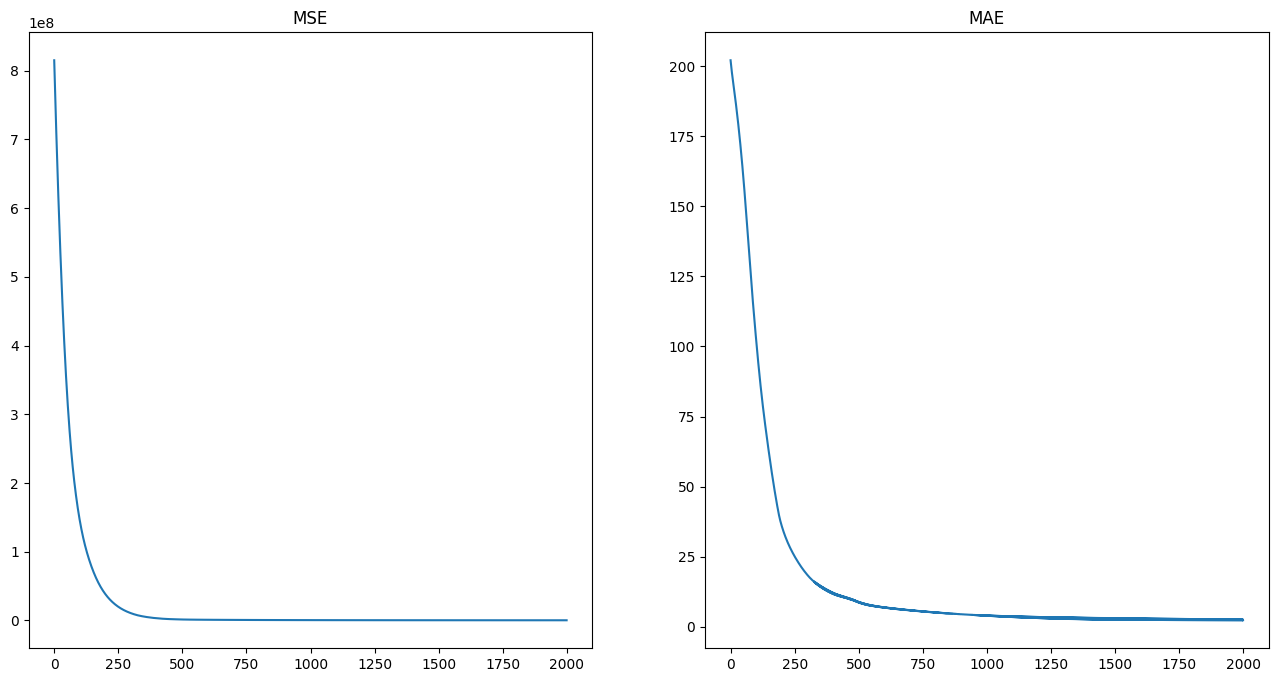

In [43]:
# отобразите эволюцию функции потерь по мере обучения сети
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(loss_history)
ax[0].set_title("MSE")
ax[1].plot(metric_history)
ax[1].set_title("MAE")



In [44]:
# примените нейросеть к данным Xtr
mu = network(normalize_X(Xtr))

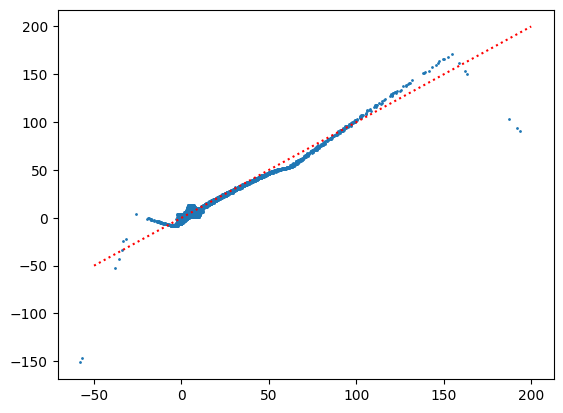

In [45]:
# отобразите диаграмму y(y_true) для оценки соответствия полученного решения известному
plt.scatter(list(ytr), list(mu), s=1)
plt.plot(np.array([-50, 0, 200]), np.array([-50, 0, 200]), linestyle = 'dotted', color = 'red')